In [1]:
import sys
import os
root_dir = os.getcwd().replace('/notebooks','')
sys.path.insert(1, root_dir)
import pandas as pd
from datetime import datetime as dt
import glob
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
from zipline.data.bundles import register, unregister
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
# from exchange_calendars.exchange_calendar_xdse import XDSExchangeCalendar
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)
from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         order_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, symbol
from pyfolio.tears import create_full_tear_sheet
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import seaborn as sns
import quantstats as qs
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [6]:
def calc_rsi(df: pd.DataFrame, window = 14):

    df['gain'] = (df['close'] - df['open']).apply(lambda x: x if x > 0 else 0)
    df['loss'] = (df['close'] - df['open']).apply(lambda x: -x if x < 0 else 0)

    df['ema_gain'] = df['gain'].ewm(span=window, min_periods=window).mean()
    df['ema_loss'] = df['loss'].ewm(span=window, min_periods=window).mean()

    df['rs'] = df['ema_gain'] / df['ema_loss']
    df['rsi_14'] = 100 - (100 / (df['rs'] + 1))
    return df

In [7]:
tickers = ['BDX','NI','ED','GEN','D','K','AMGN','CL','GILD','BIIB','EVRG','ATO','SJM','IFF','INCY','PNW','DLR','EIX','CAH','KMB','VZ','BAX','CME','CPB','AEP','CNC']

In [8]:
start_date = "2018-01-01"
end_date = "2024-01-01"
capital_base = 10000
calendar = get_calendar('NYSE')
bundle_data = bundles.load("sp500")

def initialize(context):
    context.i = 0
    # context.asset = symbol("AAPL")
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)
    context.window = 90
    context.buy_counter = 0

def handle_data(context, data):
    context.i += 1
    # skipping first 90 trading days
    if context.i <= context.window:
        return
    
    for asset in context.assets:
        buy_signal = False
        sell_signal = False

        prices = data.history(asset, ["open","close"], bar_count=90, frequency='1d')
        current_date = data.history(asset, 'price', bar_count=2, frequency='1d').index[-1]

        rsi_value = calc_rsi(prices).rsi_14[-1]

        cost_basis = context.portfolio.positions[asset].cost_basis
        amount = context.portfolio.positions[asset].amount
        cash = context.portfolio.cash
        curr_price = data.current(asset, "price")

        if rsi_value >= 70 :
            order_target_percent(asset, 0.0, stop_price=(curr_price*90))
            sell_signal = True
            context.buy_counter = 0
            print(f"date:{current_date} - sell: {sell_signal} - cash: {cash} - price:{curr_price} - RSI:{rsi_value}")
        elif rsi_value <= 30:
            order_value(asset, (cash * 0.05))
            buy_signal = True
            context.buy_counter += 1
            print(f"date:{current_date} - buy: {buy_signal} - buy_count:{context.buy_counter} - cash: {cash} - price:{curr_price} - RSI:{rsi_value}")
        else:
            pass
        
        record(Asset_price=data.current(asset, 'price'),
                    RSI=rsi_value,
                    BUY_Signal=buy_signal,
                    SELL_Signal=sell_signal,
                    Cost_Basis=cost_basis,
                    Stocks=amount)
    
    


In [9]:

result = run_algorithm(start=pd.Timestamp(start_date),
                        end=pd.Timestamp(end_date),
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=capital_base,
                        trading_calendar=calendar,
                        bundle='sp500',
                        data_frequency='daily',
                        )

date:2018-05-11 00:00:00 - sell: True - cash: 10000.0 - price:69.45 - RSI:79.12386167986173
date:2018-05-11 00:00:00 - sell: True - cash: 10000.0 - price:47.147 - RSI:76.61014066026165
date:2018-05-11 00:00:00 - sell: True - cash: 10000.0 - price:61.26 - RSI:73.82308867776398
date:2018-05-11 00:00:00 - sell: True - cash: 10000.0 - price:157.08 - RSI:72.00228497833672
date:2018-05-11 00:00:00 - sell: True - cash: 10000.0 - price:241.88 - RSI:76.45154301947329
date:2018-05-11 00:00:00 - sell: True - cash: 10000.0 - price:127.34 - RSI:75.18431125112029
date:2018-05-11 00:00:00 - sell: True - cash: 10000.0 - price:286.49 - RSI:79.62080333338965
date:2018-05-11 00:00:00 - sell: True - cash: 10000.0 - price:10.42 - RSI:99.96437723913986
date:2018-05-11 00:00:00 - sell: True - cash: 10000.0 - price:11.950000000000001 - RSI:78.18692139125778
date:2018-05-11 00:00:00 - sell: True - cash: 10000.0 - price:64.978 - RSI:74.56705274071427
date:2018-05-11 00:00:00 - sell: True - cash: 10000.0 - price

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-06-03   2019-06-03
End Period                 2019-12-31   2019-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          17.39%       4.87%
CAGR﹪                     21.11%       5.85%

Sharpe                     2.3          1.25
Prob. Sharpe Ratio         94.84%       82.61%
Smart Sharpe               1.89         1.03
Sortino                    3.25         1.82
Smart Sortino              2.68         1.5
Sortino/√2                 2.3          1.29
Smart Sortino/√2           1.89         1.06
Omega                      1.24         1.24

Max Drawdown               -6.12%       -3.26%
Longest DD Days            89           56
Volatility (ann.)          12.23%       6.69%
R^2                        0.5          0.5
Information Ratio          -0.14        -0.14
Calmar                   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-07-11,2019-08-05,2019-08-28,49,-3.257312,-2.287351
2,2019-09-17,2019-10-08,2019-10-31,45,-2.517881,-2.170126
3,2019-11-06,2019-11-20,2019-12-31,56,-2.010887,-1.938517
4,2019-06-24,2019-06-27,2019-06-28,5,-0.532897,-0.511331
5,2019-07-05,2019-07-08,2019-07-09,5,-0.460442,-0.351314


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


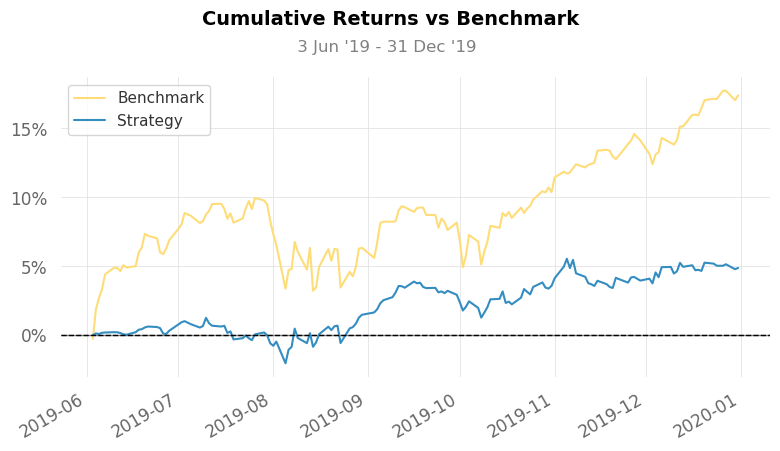

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


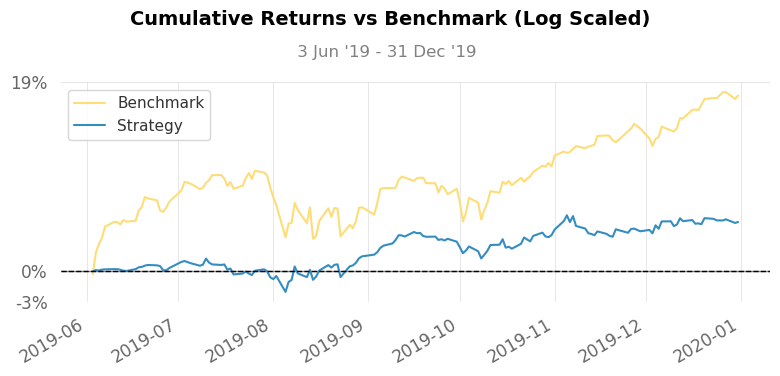

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


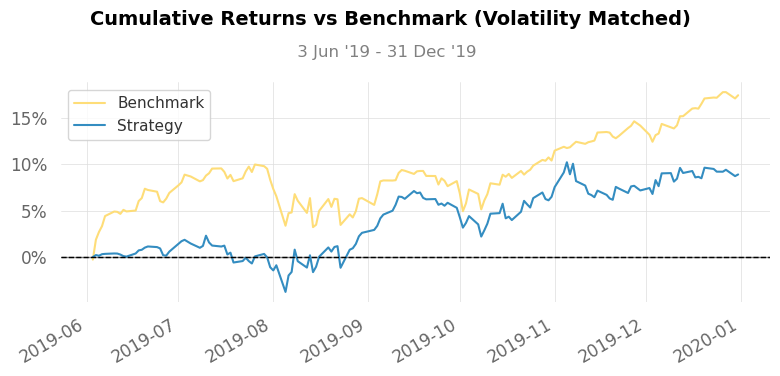

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


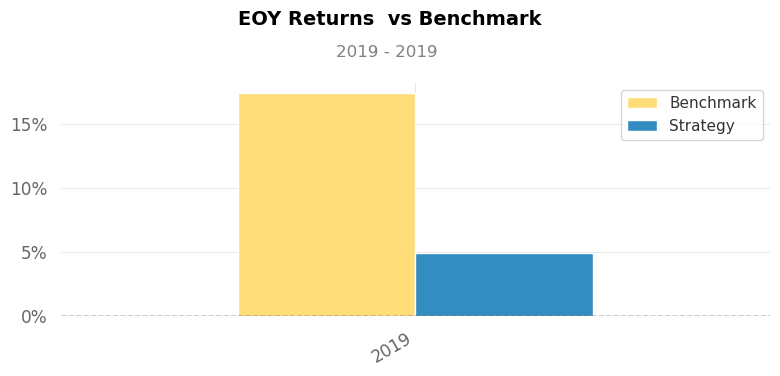

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


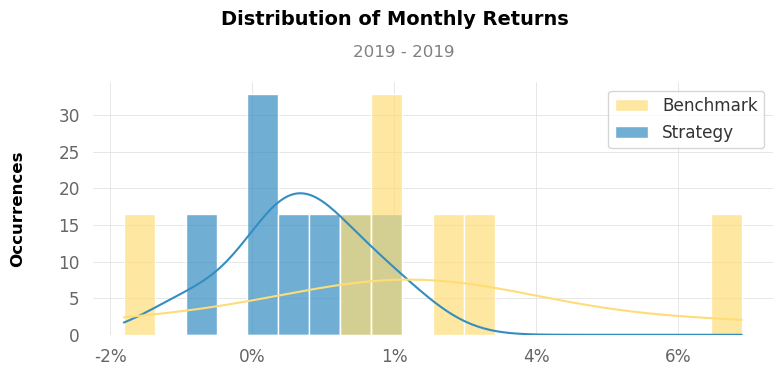

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


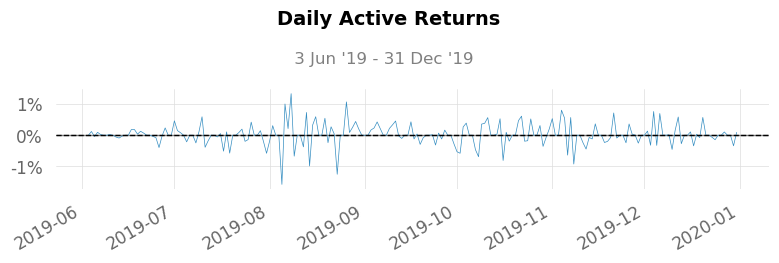

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


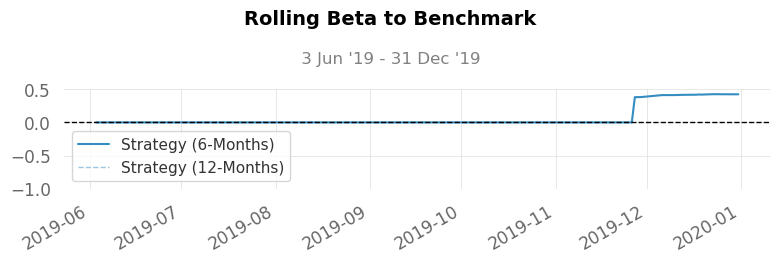

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


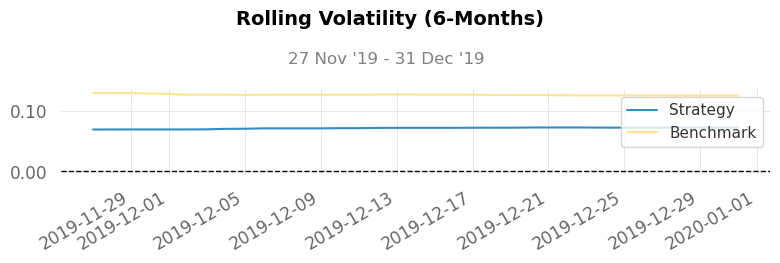

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


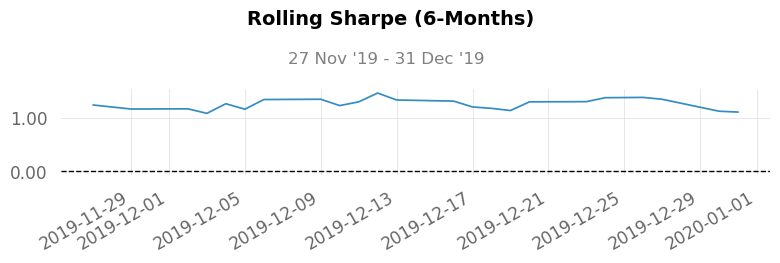

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


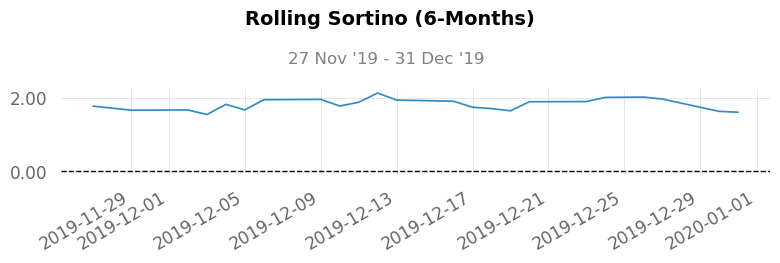

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


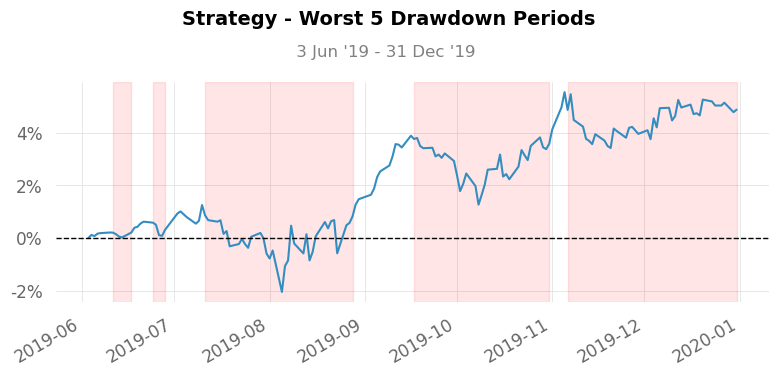

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


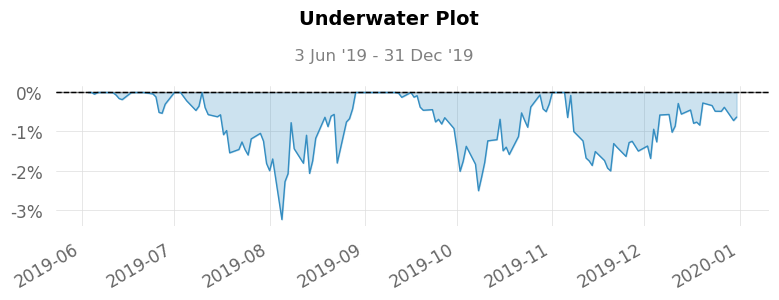

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


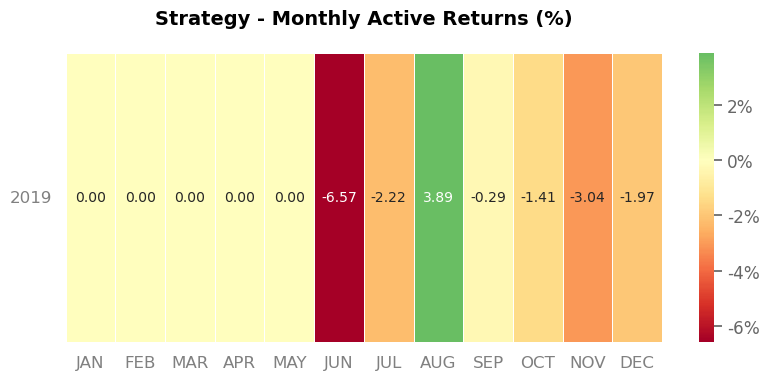

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


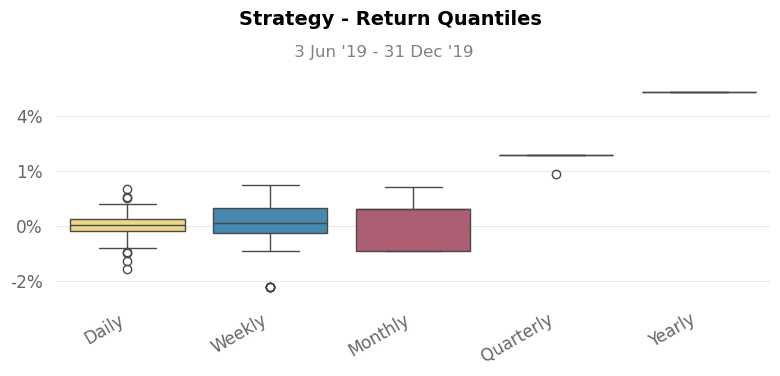

In [5]:
start = result.index[0]
end = result.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
result.index = pd.to_datetime(result.index).tz_convert(None)
result.index = benchmark.index    
qs.reports.full(result['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = result)